In [1]:
# run in the root of the repository
%cd ../..

/private/home/pfz/09-videoseal/videoseal-dev


In [64]:
import json
import argparse
import os
import omegaconf
import numpy as np
import imageio
import cv2

import subprocess
import io

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

from matplotlib import pyplot as plt
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio

from videoseal.models import Wam, build_embedder, build_extractor
from videoseal.augmentation.augmenter import Augmenter
from videoseal.evals.metrics import psnr, ssim
from videoseal.data.transforms import default_transform, normalize_img, unnormalize_img
from videoseal.data.datasets import VideoDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load video
video_dir = "assets/videos"
video_path = "assets/videos/sav_013754.mp4"
# !ffprobe -v error -show_entries stream=r_frame_rate -of default=noprint_wrappers=1:nokey=1 assets/videos/sav_013754.mp4

fps = 24 // 1
frames_per_clip = fps * 3 # 3s
frame_step = 1

vid_dataset = VideoDataset(
    folder_paths = [video_dir], 
    frames_per_clip = frames_per_clip,
    frame_step = frame_step,
    output_resolution=(1920, 1080),
)
vid = vid_dataset.__getitem__(0)
video_tensor = vid[0][0]  # (T, C, H, W)
# video_tensor = np.transpose(video_tensor, (0, 3, 1, 2))
# video_tensor = torch.tensor(video_tensor, dtype=torch.float32)
# print(f"Video tensor shape: {video_tensor.shape}")

INFO:videoseal.data.datasets:Loading videos from assets/videos
INFO:videoseal.data.datasets:Found 5 videos in assets/videos
Processing videos in assets/videos: 100%|██████████| 5/5 [00:00<00:00, 79739.62it/s]
INFO:videoseal.data.datasets:Total videos loaded from assets/videos: 5


In [4]:
from videoseal.augmentation.augmenter import Augmenter
from videoseal.modules.jnd import JND
from videoseal.models.embedder import Embedder
from videoseal.models.extractor import Extractor

class VideoWam(nn.Module):
    wm_threshold: float = 0.0
    image_format: str = "RGB"

    def __init__(
        self,
        embedder: Embedder,
        detector: Extractor,
        augmenter: Augmenter,
        attenuation: JND = None,
        scaling_w: float = 1.0,
        scaling_i: float = 1.0,
        img_size: int = 256,
        chunk_size: int = 8,
        step_size: int = 4,
        device: str = device,
    ) -> None:
        """
        WAM (watermark-anything models) model that combines an embedder, a detector, and an augmenter.
        Embeds a message into an image and detects it as a mask.

        Arguments:
            embedder: The watermark embedder
            detector: The watermark detector
            augmenter: The image augmenter
            attenuation: The JND model to attenuate the watermark distortion
            scaling_w: The scaling factor for the watermark
            scaling_i: The scaling factor for the image
        """
        super().__init__()
        # modules
        self.embedder = embedder
        self.detector = detector
        self.augmenter = augmenter
        self.attenuation = attenuation
        # scalings
        self.scaling_w = scaling_w
        self.scaling_i = scaling_i
        # video settings
        self.chunk_size = chunk_size  # encode 8 imgs at a time
        self.step_size = step_size  # propagate the wm to 4 next imgs
        self.resize_to = transforms.Resize((img_size, img_size), antialias=True)
        # device
        self.device = device

    def get_random_msg(self, bsz: int = 1, nb_repetitions=1) -> torch.Tensor:
        return self.embedder.get_random_msg(bsz, nb_repetitions)  # b x k

    @torch.no_grad()
    def embed_inference(
        self,
        imgs: torch.Tensor,
        msg: torch.Tensor = None,
    ) -> torch.Tensor:
        """ 
        Does the forward pass of the encoder only.
        Rescale the watermark signal by a JND (just noticeable difference heatmap) that says where pixel can be changed without being noticed.
        The watermark signal is computed on the image downsampled to 256x... pixels, and then upsampled to the original size.
        The watermark signal is computed every step_size imgs and propagated to the next step_size imgs.

        Args:
            imgs: (torch.Tensor) Batched images with shape FxCxHxW
            msg: (torch.Tensor) Batched messages with shape 1xL
        
        Returns:
            imgs_w: (torch.Tensor) Batched watermarked images with shape FxCxHxW
        """
        if msg is None:
            msg = self.get_random_msg()

        # encode by chunk of 8 imgs, propagate the wm to 4 next imgs
        chunk_size = self.chunk_size  # n
        step_size = self.step_size
        msg = msg.repeat(chunk_size, 1).to(self.device) # 1 k -> n k

        # initialize watermarked imgs
        imgs_w = torch.zeros_like(imgs) # f 3 h w

        for ii in range(0, len(imgs[::step_size]), chunk_size):
            nimgs_in_ck = min(chunk_size, len(imgs[::step_size]) - ii)
            start = ii*step_size
            end = start + nimgs_in_ck * step_size
            all_imgs_in_ck = imgs[start : end, ...].to(self.device) # f 3 h w

            # choose one frame every step_size
            imgs_in_ck = all_imgs_in_ck[::step_size] # n 3 h w
            # downsampling with fixed short edge
            imgs_in_ck = self.resize_to(imgs_in_ck) # n 3 wm_h wm_w
            # deal with last chunk that may have less than chunk_size frames
            if nimgs_in_ck < chunk_size:  
                msg = msg[:nimgs_in_ck]
            
            # get deltas for the chunk, and repeat them for each frame in the chunk
            deltas_in_ck = self.embedder(imgs_in_ck, msg) # n 3 wm_h wm_w
            deltas_in_ck = torch.repeat_interleave(deltas_in_ck, step_size, dim=0) # f 3 wm_h wm_w
            deltas_in_ck = deltas_in_ck[:len(all_imgs_in_ck)] # at the end of video there might be more deltas than needed
            
            # upsampling
            deltas_in_ck = nn.functional.interpolate(deltas_in_ck, size=imgs.shape[-2:], mode='bilinear', align_corners=True)
            
            # create watermarked imgs
            all_imgs_in_ck_w = self.scaling_i * all_imgs_in_ck + self.scaling_w * deltas_in_ck
            if self.attenuation is not None:
                all_imgs_in_ck_w = self.attenuation(all_imgs_in_ck, all_imgs_in_ck_w)
            imgs_w[start : end, ...] = all_imgs_in_ck_w.cpu() # n 3 h w

        return imgs_w

    @torch.no_grad()
    def detect_inference(
        self,
        frames: torch.Tensor,
        aggregation: str = "avg",
    ) -> torch.Tensor:
        """
        Does the forward pass of the detector only.
        Rescale the image to 256x... pixels, and then compute the mask and the message.
        
        Args:
            imgs: (torch.Tensor) Batched images with shape FxCxHxW
        """
        frames = self.resize_to(frames)
        chunksize = 16  # n
        all_preds = []
        for ii in range(0, len(frames), chunksize):
            nframes_in_ck = min(chunksize, len(frames) - ii)
            preds = self.detector(
                frames[ii:ii+nframes_in_ck].to(self.device)
            ).cpu()
            all_preds.append(preds)  # n k ..
        preds = torch.cat(all_preds, dim=0) # f k ..
        mask_preds = preds[:, 0:1]  # b ..
        bit_preds = preds[:, 1:]  # b k ..

        if aggregation is None:
            decoded_msg = bit_preds
        elif aggregation == "avg":
            decoded_msg = bit_preds.mean(dim=0)
        elif aggregation == "weighted_avg":
            decoded_msg = (bit_preds * bit_preds.abs()).mean(dim=0) # b k -> k
        msg = (decoded_msg > 0).squeeze().numpy()
        return msg

In [5]:
def load_model_from_checkpoint(exp_dir, exp_name):
    logfile_path = os.path.join(exp_dir, 'logs', exp_name + '.stdout')
    ckpt_path = os.path.join(exp_dir, exp_name, 'checkpoint.pth')

    # Load parameters from log file
    with open(logfile_path, 'r') as file:
        for line in file:
            if '__log__:' in line:
                params = json.loads(line.split('__log__:')[1].strip())
                break

    # Create an argparse Namespace object from the parameters
    args = argparse.Namespace(**params)
    print(args)
    
    # Load configurations
    for path in [args.embedder_config, args.extractor_config, args.augmentation_config]:
        path = os.path.join(exp_dir, "code", path)
    # embedder
    embedder_cfg = omegaconf.OmegaConf.load(args.embedder_config)
    args.embedder_model = args.embedder_model or embedder_cfg.model
    embedder_params = embedder_cfg[args.embedder_model]
    # extractor
    extractor_cfg = omegaconf.OmegaConf.load(args.extractor_config)
    args.extractor_model = args.extractor_model or extractor_cfg.model
    extractor_params = extractor_cfg[args.extractor_model]
    # augmenter
    augmenter_cfg = omegaconf.OmegaConf.load(args.augmentation_config)
    
    # Build models
    embedder = build_embedder(args.embedder_model, embedder_params, args.nbits)
    extractor = build_extractor(extractor_cfg.model, extractor_params, args.img_size_extractor, args.nbits)
    augmenter = Augmenter(**augmenter_cfg)
    
    # Build the complete model
    wam = VideoWam(embedder, extractor, augmenter, 
                   scaling_w=args.scaling_w, scaling_i=args.scaling_i)
    
    # Load the model weights
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path, map_location='cpu')
        wam.load_state_dict(checkpoint['model'])
        print("Model loaded successfully from", ckpt_path)
        print(line)
    else:
        print("Checkpoint path does not exist:", ckpt_path)
    
    return wam

# Example usage
exp_dir = '/checkpoint/pfz/2024_logs/0911_vseal_pw'
exp_name = '_extractor_model=sam_tiny'

wam = load_model_from_checkpoint(exp_dir, exp_name)
wam.eval()
wam.to(device)

Namespace(train_dir='/datasets01/COCO/060817/train2014/', train_annotation_file='/datasets01/COCO/060817/annotations/instances_train2014.json', val_dir='/datasets01/COCO/060817/val2014/', val_annotation_file='/datasets01/COCO/060817/annotations/instances_val2014.json', output_dir='/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny', embedder_config='configs/embedder.yaml', augmentation_config='configs/simple_augs.yaml', extractor_config='configs/extractor.yaml', attenuation_config='configs/attenuation.yaml', embedder_model='unet_small2', extractor_model='sam_tiny', nbits=32, img_size=256, img_size_extractor=256, attenuation='None', scaling_w=0.4, scaling_w_schedule=None, scaling_i=1.0, threshold_mask=0.6, optimizer='AdamW,lr=1e-4', optimizer_d=None, scheduler='CosineLRScheduler,lr_min=1e-6,t_initial=100,warmup_lr_init=1e-6,warmup_t=5', epochs=100, batch_size=16, batch_size_eval=32, temperature=1.0, workers=8, resume_from=None, lambda_det=0.0, lambda_dec=1.0, lambda_i=0.0

/tmp/ipykernel_602910/4022889192.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


Model loaded successfully from /checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny/checkpoint.pth
__log__:{"train_dir": "/datasets01/COCO/060817/train2014/", "train_annotation_file": "/datasets01/COCO/060817/annotations/instances_train2014.json", "val_dir": "/datasets01/COCO/060817/val2014/", "val_annotation_file": "/datasets01/COCO/060817/annotations/instances_val2014.json", "output_dir": "/checkpoint/pfz/2024_logs/0911_vseal_pw/_extractor_model=sam_tiny", "embedder_config": "configs/embedder.yaml", "augmentation_config": "configs/simple_augs.yaml", "extractor_config": "configs/extractor.yaml", "attenuation_config": "configs/attenuation.yaml", "embedder_model": "unet_small2", "extractor_model": "sam_tiny", "nbits": 32, "img_size": 256, "img_size_extractor": 256, "attenuation": "None", "scaling_w": 0.4, "scaling_w_schedule": null, "scaling_i": 1.0, "threshold_mask": 0.6, "optimizer": "AdamW,lr=1e-4", "optimizer_d": null, "scheduler": "CosineLRScheduler,lr_min=1e-6,t_initi

VideoWam(
  (embedder): UnetEmbedder(
    (unet): UNetMsg(
      (msg_processor): MsgProcessor(
        (msg_embeddings): Embedding(64, 64)
      )
      (inc): ResnetBlock(
        (double_conv): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ChanRMSNorm()
          (2): SiLU()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): ChanRMSNorm()
          (5): SiLU()
        )
        (res_conv): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      )
      (downs): ModuleList(
        (0): DBlock(
          (down): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (conv): ResnetBlock(
            (double_conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): ChanRMSNorm()
              (2): SiLU()
              (3): Conv2d(32, 32, kernel_size=(3, 3), strid

In [6]:
attenuation_cfg = "configs/attenuation.yaml"
attenuation = "jnd_1_3"
attenuation_cfg = omegaconf.OmegaConf.load(attenuation_cfg)[attenuation]
attenuation = JND(**attenuation_cfg).to(device)
attenuation.preprocess = unnormalize_img
attenuation.postprocess = normalize_img

wam.attenuation = attenuation
wam.scaling_w = 2.0
wam.scaling_i = 1.0

# wam.attenuation = None
# wam.scaling_w = 0.4
# wam.scaling_i = 1.0

In [7]:
msg = wam.get_random_msg()

vid = normalize_img(video_tensor / 255)
vid_w = wam.embed_inference(vid, msg)
preds = wam.detect_inference(vid_w)

psnr_val = psnr(vid_w, vid).mean().item()
ssim_val = ssim(vid_w, vid).mean().item()
bit_acc = (msg == preds).float().mean().item()
print(f"PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.2f}, Bit accuracy: {bit_acc:.2f}")

PSNR: 38.30, SSIM: 0.99, Bit accuracy: 0.81


In [8]:
# !ffmpeg -i output_w.mp4 -i  output_o.mp4 -filter_complex ssim -f null - 2>&1 | grep " SSIM "
# # https://stackoverflow.com/questions/62061410/can-someone-help-me-to-install-the-netflixs-vmaf-library-in-ubuntu
# !ffmpeg -i output_w.mp4 -i  output_o.mp4 -filter_complex libvmaf

In [21]:
def save_vid(vid, out_path, fps):
    video_tensor_w = unnormalize_img(vid)
    video_tensor_w = video_tensor_w.clamp(0, 1)
    video_tensor_w = video_tensor_w.numpy()
    video_tensor_w = 255 * np.transpose(video_tensor_w, (0, 2, 3, 1))
    torchvision.io.write_video(out_path, video_tensor_w, fps=fps, video_codec='libx264', options={'crf': '21'})

def get_fps(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    cap.release()
    return fps, frame_count

out_path = "output_w.mp4"
out_path_ori = "output_o.mp4"
save_vid(vid_w, out_path, fps)
save_vid(vid, out_path_ori, fps)

# get video fps and durations
fps, frame_count = get_fps(out_path)
duration = frame_count / fps
ori_fps, ori_frame_count = get_fps(video_path)
ori_duration = ori_frame_count / ori_fps
print(f"Output video fps: {fps}, duration: {duration:.2f}s, Original video fps: {ori_fps}, duration: {ori_duration:.2f}s")

# get sizes
size = os.path.getsize(out_path) / 1e6
original_size = os.path.getsize(video_path) / 1e6
size_per_sec = size / duration
original_size_per_sec = original_size / ori_duration
print(f"Output video size: {size:.2f} MB, Original video size: {original_size:.2f} MB")
print(f"Output video size per sec: {size_per_sec:.2f} MB, Original video size per sec: {original_size_per_sec:.2f} MB")

Output video fps: 24.0, duration: 3.00s, Original video fps: 24.0, duration: 13.25s
Output video size: 4.70 MB, Original video size: 16.50 MB
Output video size per sec: 1.57 MB, Original video size per sec: 1.25 MB


In [96]:
import av

save_path = "/private/home/pfz/09-videoseal/videoseal-dev/output_comp.mp4"
def compress_video_with_ffmpeg(video_tensor, 
    fps=24, codec='libx264', crf=18, videoformat='MP4',
    gop=10, keyint_min=5,
    output=True, 
    save=False,
) -> torch.Tensor:
    """
    Compress a video tensor using FFmpeg.
    Args:
        video_tensor (torch.Tensor): Video tensor of shape (T, C, H, W), normalized
        codec (str): FFmpeg codec. Defaults to 'libx264'.
        crf (int): Quality setting for the codec. Lower values result in higher quality and larger files. Defaults to 18.
    Returns:
        torch.Tensor: Compressed video tensor.
    """
    # normalize video tensor and convert to np uint8 array
    video_tensor = unnormalize_img(video_tensor)
    video_tensor = video_tensor.clamp(0, 1).permute(0, 3, 2, 1)  # t c h w -> t h w c
    video_array = (video_tensor * 255).to(torch.uint8).numpy()
    # create input pipe
    input_pipe = io.BytesIO()
    for frame in video_array:
        frame_bytes = frame.tobytes()
        input_pipe.write(frame_bytes)
        # Set up FFmpeg command
    command = [
        '/bin/ffmpeg',
        # The path to the FFmpeg executable. Use /bin/ instead of the one in the conda environment.
        '-f', 'rawvideo',  
        # The -f option specifies the format of the input file. In this case, it's set to 'rawvideo', which tells FFmpeg that the input is raw video data (i.e., not wrapped in a container like MP4 or AVI).
        '-r', str(fps),
        # The -r option sets the frame rate of the output video. 
        '-s', '{}x{}'.format(video_tensor.shape[-3], video_tensor.shape[-2]),  # Width x Height
        # '-s', 'same',
        # The -s option sets the resolution of the output video. 
        '-pix_fmt', 'rgb24',
        # The -pix_fmt option specifies the pixel format of the input video. In this case, it's set to 'rgb24', which means each pixel is represented by 24 bits (8 bits for red, green, and blue components, respectively).
        '-i', 'pipe:0',  # Input from stdin
        # The -i option specifies the input file. In this case, it's set to 'pipe:0', which tells FFmpeg to read the input video data from stdin.
        '-c:v', codec,
        # The -c:v option specifies the video codec to use for encoding the output video. 
        '-crf', str(crf),
        # The -crf option specifies the quality setting for the codec. Lower values result in higher quality and larger files
        '-g', str(gop),  
        # The -g option sets the maximum Group of Pictures (GOP) size. A GOP is a sequence of frames that starts with an I-frame (intra-coded frame) and ends before the next I-frame. Setting the GOP size to 1 forces every frame to be an I-frame, which can improve compression efficiency but may increase the file size.
        '-keyint_min', str(keyint_min),
        # The -keyint_min option sets the minimum interval between keyframes (I-frames). Setting it to 1 ensures that every frame is a keyframe, which can improve seeking performance but may increase the file size.
        '-f', videoformat,  
        # The -f option specifies the format of the output file. In this case, it's set to 'matroska', which is a container format that can contain video, audio, and subtitles (mkv stands for Matroska Video).
        ''  
        # Output changed to pipe:1 to get the output video as a byte stream, or to a file name to save the output video to a file.
    ]
    if save:
        command[-1] = save_path
        if os.path.exists(save_path):
            os.remove(save_path)
        # run FFmpeg
        process = subprocess.Popen(command, stdin=subprocess.PIPE)
        process.communicate(input=input_pipe.getvalue())
    if output:
        command[-1] = 'pipe:1'
        # run FFmpeg
        process = subprocess.Popen(command, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
        output, _ = process.communicate(input=input_pipe.getvalue())
        # read compressed video

        # # v2
        # container = av.open(io.BytesIO(output), mode='r')
        # compressed_video = []
        # for frame in container.decode(video=0):
        #     frame = frame.to_rgb().to_ndarray()
        #     # print(frame)
        #     frame = torch.tensor(frame, dtype=torch.float32) / 255
        #     frame = frame.permute(2, 0, 1)
        #     compressed_video.append(frame)
        # compressed_video = torch.stack(compressed_video)
        # return compressed_video

        # v1
        with io.BytesIO(output) as f:
            container = av.open(f)
            stream = next(s for s in container.streams if s.type == 'video')
            compressed_video = []
            for packet in container.demux(stream):
                for frame in packet.decode():
                    # img = frame.to_image()
        #             compressed_video.append(img)
        # return compressed_video
                    img = frame.to_ndarray()
                    compressed_video.append(torch.from_numpy(img))
            compressed_video = torch.stack(compressed_video)
        return compressed_video

compressed_video = compress_video_with_ffmpeg(
    vid_w, 
    fps=fps, codec='h264', crf=18, 
    gop=50, keyint_min=45,
    save=True, 
    output=True)
print(vid_w.shape)
print(compressed_video.shape)
# fps, frames = get_fps(save_path)
# size = os.path.getsize(save_path) / 1e6
# print(f"Output video size: {size:.2f} MB - {fps} fps - {frames} frames")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

InvalidDataError: [Errno 1094995529] Invalid data found when processing input: '<none>'

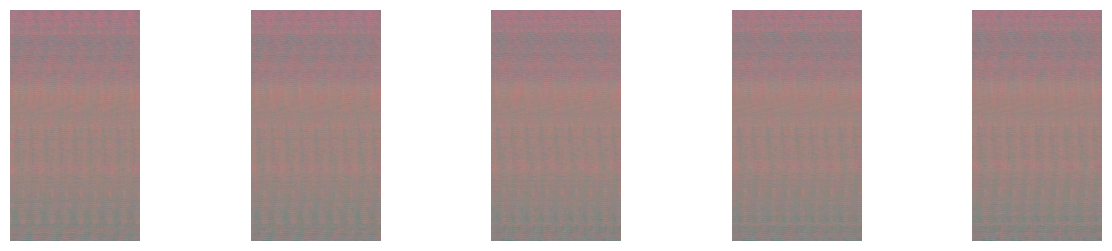

In [95]:
# compressed_video[0]
# compressed_video.shape -> torch.Size([72, c, h, w])
def plot_images_from_video(video_tensor, n=5):
    n = min(n, video_tensor.shape[0])
    fig, axes = plt.subplots(1, n, figsize=(n*3, 3))
    for i in range(n):
        axes[i].imshow(video_tensor[i].permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()

plot_images_from_video(compressed_video, n=5)

In [ ]:
# Codecs:
#  D..... = Decoding supported
#  .E.... = Encoding supported
#  ..V... = Video codec
#  ..A... = Audio codec
#  ..S... = Subtitle codec
#  ...I.. = Intra frame-only codec
#  ....L. = Lossy compression
#  .....S = Lossless compression
# !ffmpeg -codecs
!/bin/ffmpeg -codecs | grep 'EV'

In [ ]:
# Codecs:
#  D..... = Decoding supported
#  .E.... = Encoding supported
#  ..V... = Video codec
#  ..A... = Audio codec
#  ..S... = Subtitle codec
#  ...I.. = Intra frame-only codec
#  ....L. = Lossy compression
#  .....S = Lossless compression
# !ffmpeg -codecs
!/bin/ffmpeg -codecs | grep 'EV'